<a href="https://colab.research.google.com/github/dpatinoecheverri/ENV717_S23/blob/main/L9_UC_NoRampingConstraints_NoSDSUCosts_NoReservesCOLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENV717 L9 - UNIT COMMITMENT PROBLEM - SIMPLIFIED

#### Data from Handout Lessons 8 & 9
##### Constraints Included:  Pmin, Pmax, Demand Balance constraints
#### Costs included: Fixed and variable
##### Work on your own to include all that is missing:  a) StartUp and ShutDown costs. b)Ramping constraints. c)Reserve requirements d) min up time e) min downtime

### Mount the drive to colab

In [1]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')
#save path
path = "/content/gdrive/MyDrive/ENV717-S2023/"

Mounted at /content/gdrive


### Install pyomo

In [2]:
!pip install pyomo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 7.2 MB/s eta 0:00:00


### Install the glpk solver

In [3]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 128048 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.7.1+dfsg-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.7.1+dfsg-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-2_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-2) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-2_amd64.deb ...
Unpacking glpk-utils (4.65-2) ...
Setting up libsuitesparseconfig5:amd64 (1:5.7.1+dfsg-2) ...
Setting up libamd2:amd64 (1:5.7.1+

### Import the libraries. Specify that we will be using glpk solver from the SolverFactory()class or the pyomo library

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
opt = SolverFactory('cplex')

In [10]:
#Change the working directory to the folder where all the data a nd files for this course are stored
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/ENV717-S2023')


In [11]:
#Read generators and demand data as two dataframes
df_genData=pd.read_excel(io="L9-UCData.xlsx",sheet_name="GeneratorsData",skiprows=1) #read data from generators tab and skip the first row
df_demandData=pd.read_excel(io="L9-UCData.xlsx",sheet_name="DemandData",skiprows=1) #read data from generators tab and skip the first row

In [12]:
#define the size of the sets
NumGen=len(df_genData)
T=len(df_demandData)
print("We read technical parameters data for", NumGen, "power generating units")
print("We read demand data for", T, "time periods")

We read technical parameters data for 2 power generating units
We read demand data for 24 time periods


In [13]:
#Define Indexes
N=np.array([n for n in range(0,NumGen)]) #This array has 2 components, but the index starts at zero
T=np.array([t for t in range(0,T)])

In [14]:
df_genData.columns

Index(['FixedCost', 'SDCost', 'SUCost', 'VarCost', 'MaxGen', 'MinGen',
       'RampDown', 'RampSD', 'RampSU', 'RampUp', 'MinUpTime', 'MinDownTime',
       'ReqUp', 'ReqDown', 'InitialStatus', 'InitialGen'],
      dtype='object')

In [36]:
#get the NamePlate capacity of the largest generator to use it as the upper bound of the pg,t, decision variables
#This step is optional. You can leave pg,t unbounded.
largestGen=df_genData.loc[df_genData["MaxGen"].idxmax()] #largestGen is a series object 
print('The parameters of the generator with largest Gen capacity are',largestGen)
MaxGenCapacity=largestGen.MaxGen 
print("The Name Plate Capacity of the largest generator is",MaxGenCapacity)

The parameters of the generator with largest Gen capacity are FixedCost            6
SDCost             400
SUCost           11000
VarCost             26
MaxGen             600
MinGen              60
RampDown           200
RampSD             600
RampSU             200
RampUp             100
MinUpTime            0
MinDownTime          0
ReqUp                0
ReqDown              0
InitialStatus        1
InitialGen         100
Name: 1, dtype: int64
The Name Plate Capacity of the largest generator is 600


In [29]:
FixCost=df_genData.loc[:,'FixedCost'].to_numpy()
SDCost=df_genData.loc[:,'SDCost'].to_numpy()
SUCost=df_genData.loc[:,'SUCost'].to_numpy()
VarCost=df_genData.loc[:,'VarCost'].to_numpy()
PMax=df_genData.loc[:,'MaxGen'].to_numpy()
PMin=df_genData.loc[:,'MinGen'].to_numpy()
Demand=df_demandData.loc[:,'Demand'].to_numpy()

In [30]:
print(Demand)

[200 230 270 280 260 270 290 330 350 370 400 410 420 420 380 360 340 300
 300 310 290 280 260 250]


In [31]:
#UC MODEL
def Unit_Commitment():
    m=ConcreteModel()
    m.N=Set(initialize=N)
    m.T=Set(initialize=T)
    m.x=Var(m.N, m.T, bounds = (0,MaxGenCapacity))
    m.u=Var(m.N, m.T, domain=Binary)
    m.system_cost=Objective(expr=sum(m.x[n,t]*VarCost[n]+m.u[n,t]*FixCost[n] for n in m.N for t in m.T), sense=minimize)
    m.DemandConstraint=Constraint(m.T, rule=lambda m, t: sum(m.x[n,t] for n in N) == Demand[t])
    m.MinPower=Constraint(m.N, m.T, rule=lambda m, n, t: PMin[n]*m.u[n,t] <= m.x[n,t])
    m.MaxPower=Constraint(m.N, m.T, rule=lambda m, n, t: PMax[n]*m.u[n,t] >= m.x[n,t])
    return m

In [33]:
m=Unit_Commitment()
SolverFactory('glpk').solve(m).write() # Instead of this line, write "opt.solve(m)" if model's details are not important

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 190336.0
  Upper bound: 190336.0
  Number of objectives: 1
  Number of constraints: 121
  Number of variables: 97
  Number of nonzeros: 241
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 9
      Number of created subproblems: 9
  Error rc: 0
  Time: 0.02474069595336914
# ----------------------------------------------------------
#   Solution Information
# --------------------------

In [34]:
print('SOLUTION')
print('The total system cost is = $',m.system_cost())
print('Commitment and Generation')
for n in N:
    for t in T:
        print("n = {0:2d}  t = {1:2d}   {2} {3:.1f}  {4:.2f}".format(n, t, m.u[n,t], m.u[n,t](), m.x[n,t]()))
        #Line above makes columns the same width and formats the numbers of decimals for u and x. Line below has a messy format
        #print(m.x[n,t]," = ", m.x[n,t](), "MWh", m.u[n,t], " =", m.u[n,t]()) #this works too but format is messy

SOLUTION
The total system cost is = $ 190336.0
Commitment and Generation
n =  0  t =  0   u[0,0] 1.0  200.00
n =  0  t =  1   u[0,1] 1.0  230.00
n =  0  t =  2   u[0,2] 1.0  270.00
n =  0  t =  3   u[0,3] 1.0  280.00
n =  0  t =  4   u[0,4] 1.0  260.00
n =  0  t =  5   u[0,5] 1.0  270.00
n =  0  t =  6   u[0,6] 1.0  290.00
n =  0  t =  7   u[0,7] 1.0  270.00
n =  0  t =  8   u[0,8] 1.0  290.00
n =  0  t =  9   u[0,9] 1.0  300.00
n =  0  t = 10   u[0,10] 1.0  300.00
n =  0  t = 11   u[0,11] 1.0  300.00
n =  0  t = 12   u[0,12] 1.0  300.00
n =  0  t = 13   u[0,13] 1.0  300.00
n =  0  t = 14   u[0,14] 1.0  300.00
n =  0  t = 15   u[0,15] 1.0  300.00
n =  0  t = 16   u[0,16] 1.0  280.00
n =  0  t = 17   u[0,17] 1.0  300.00
n =  0  t = 18   u[0,18] 1.0  300.00
n =  0  t = 19   u[0,19] 1.0  250.00
n =  0  t = 20   u[0,20] 1.0  290.00
n =  0  t = 21   u[0,21] 1.0  280.00
n =  0  t = 22   u[0,22] 1.0  260.00
n =  0  t = 23   u[0,23] 1.0  250.00
n =  1  t =  0   u[1,0] 0.0  0.00
n =  1  t =  1 

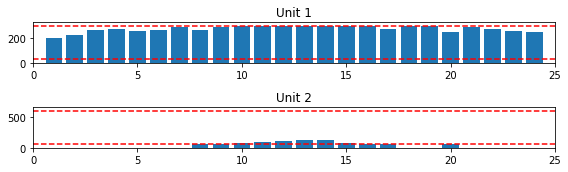

In [35]:
#Graph solution
#For each power unit and time period, plot its power production and reference lines of Pmin and Pmax 

fig, ax = plt.subplots(max(N)+1, 1, figsize=(8, 1.5*max(N)+1)) #Create a matrix of subplots with max(N)+1 rows and 1 column
for n in N:
    ax[n].bar(T+1, [m.x[n,t]() for t in T])
    ax[n].set_xlim(0, max(T)+2)
    ax[n].set_ylim(0, 1.1*PMax[n])
    ax[n].plot(ax[n].get_xlim(), np.array([PMax[n], PMax[n]]), 'r--')
    ax[n].plot(ax[n].get_xlim(), np.array([PMin[n], PMin[n]]), 'r--')
    ax[n].set_title('Unit ' + str(n+1))
fig.tight_layout()